# Tweet Sentiment Classification

# Overview of Process (CRISP-DM)
I will be following the Cross-Industry Standard Process for Data Mining to build a classifier that will determine the sentiment of tweets.  The CRISP-DM process includes the following key steps:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation

# 1. Business Understanding
The overall goal of this process is to create a classifier that can label tweets based on their sentiment (positive, negative, or neutral).  This classifier will be created in the context of tracking public sentiment surrounding various product releases / events. Stakeholders for this project are likely product managers / investor and public relations professionals who are invested in how the public is feeling towards newly released products, and various other business proceedings. In conjunction with other tools, companies could use this classifier to create a sentiment score based on a certain number of recent tweets, and track that over time to monitor changes in sentiment over time. Additionally, companies could pull down a batch of tweets at certain times, filtered for various products or topics. If a broad enough sample is used, it could likely help provide good insight into whether consumers are feeling neutral, positive, or negative towards recent releases. 

According to https://www.internetlivestats.com/twitter-statistics/, there are over 500 million tweets sent per day.  Harnessing public sentiment from this amount of data would undoubtedly be helpful for tech companies looking to track how the public is feeling towards them.  This classifier would likely be a valuable tool to complement public product reviews. 

# 2. Data Understanding

The main dataset used throughout this data science process will be coming from CrowdFlower via the following url: `https://data.world/crowdflower/brands-and-product-emotions`. 

The following summary of the dataset is provided on CrowdFlower:

*Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.*

As the dataset contains labels classifying the tweet as positive, negative, or neutral, along with detailed tweet text, the dataset available is a good match for our business goals. 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow

Using TensorFlow backend.


In [2]:
# set style of visualizations
plt.style.use('ggplot')

In [3]:
# failure to specify 'latin1' encoding results in errors
# error_df = pd.read_csv('judge-1377884607_tweet_product_company.csv')
# error_df.head()

In [4]:
# load dataset
raw_df = pd.read_csv('data/raw_tweets.csv', encoding='latin_1')

In [5]:
# print first rows of dataset to ensure loaded correctly
raw_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# show info of df
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Looking at the above outputs, we can see that there are a total of 9,093 entries in our dataset, with a total of three columns.  Raw text from tweets is held in the `tweet_text` column; sentiment is held in the `is_there_an_emotion_directed_at_a_brand_or_product`; and the item of emotion direction is held in the `emotion_in_tweet_is_directed_at` column.  

The datset occupies just over 213.2 KB of storage.

From first glance, we can likely drop the `emotion_in_tweet_is_directed_at` column as we are more interested in whether sentiment in a given tweet is positive, neutral, or negative based on the text.  Main predictors we will use is processed features derived from the `tweet_text` column.

Our target variable, which can also be thought of as our class labels are held in the `is_there_an_emotion_directed_at_a_brand_or_product` column.  

In [7]:
# display value counts
display(raw_df['emotion_in_tweet_is_directed_at'].value_counts())
display(raw_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Unsurprising given the origin of our dataset, the products identified are either Apple or Google products.  Looking at sentiment, the majority of entries seem to fall under a neutral sentiment ('No emotion toward brand or product'), with the next largest group being tagged as 'Positive emotion'.  There is some clear class imbalance present with only 570 entries belonging to the 'Negative emotion' class. The lack of negative sentiment labels is likely a weakness of this dataset. 

In [8]:
# rename columns so easier to work with
df = raw_df.copy()
df.columns = ['text', 'product_brand', 'sentiment']
df.head()

,text,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
# explore potential missing values
df.isna().sum()

text                1
product_brand    5802
sentiment           0
dtype: int64

We see that there is only one missing value in the text column, 0 in the sentiment column, and a large number (5802) in the product_brand column.  Given we are planning to work the majority of the time with the text and sentiment columns, this will not likely pose a large issue. 

In [10]:
# display missing value in the text column
df.loc[df['text'].isna()]

,text,product_brand,sentiment
6,NaN,NaN,No emotion toward brand or product


In [11]:
# display missing values in the product_brand column
df.loc[df['product_brand'].isna()]

,text,product_brand,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [12]:
# display sentiment breakdowns of missing product_brand entries
df.loc[df['product_brand'].isna()]['sentiment'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: sentiment, dtype: int64

We see that the majority of missing product_brand values are also labeled as no emotion twoard brand or product, which makes sense as a lot of the neutral-labeled tweets may not be directed at a specific brand or product, and therefore would be missing a product_brand tagging.  Additionally, this column will not be used in our process of tweet classification. 

Drop unnecessary columns and handle missing value for additional EDA.

In [13]:
# drop product_brand column
clean_df = df.drop(['product_brand'], axis=1)

# handle missing values
clean_df = clean_df.dropna(subset=['text'])
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   sentiment  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [14]:
# further examine tweets labeled as "I can't tell"
for i in range(10):
    display(clean_df.loc[clean_df['sentiment'] == "I can't tell"].iloc[i][0])

'Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh'

'\x89ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow'

'Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw'

'The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw'

"Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}"

'SYD #SXSW crew your iPhone extra juice pods have been procured.'

'Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}'

'Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse'

'Catch 22\x89Û_ I mean iPad 2 at #SXSW : {link}'

'Forgot my iPhone for #sxsw. Android only. Knife to a gun fight'

Looking at a sample of the tweets labeled as "I can't tell", there is no clear class label that each should belong to.  Given this, and the small number of tweets with this class distinction, they will be removed from the dataset. 

In [15]:
# separate dataset into tweets and class_labels
tweets = clean_df['text']
class_labels = clean_df['sentiment']

In [16]:
# tokenize tweets and print the total vocabulary size of our dataset
tokenized = list(map(nltk.word_tokenize, tweets.dropna())) 
raw_tweet_vocab = set()
for tweet in tokenized:
    raw_tweet_vocab.update(tweet)
print(len(raw_tweet_vocab))

13212


Looking at the text within the tweets, there is a total vocabulary size of just over 13,200.

In [17]:
# print average tweet size
mean_tweet_size = []
for tweet in tokenized:
    mean_tweet_size.append(len(tweet))
round(np.mean(mean_tweet_size), 2)

24.41

The average tweet size within the dataset is just over 24 words. 

In [18]:
# display frequency distribution of raw dataset
tweets_concat = []
for tweet in tokenized:
    tweets_concat += tweet
    
# display the 15 most common words
unprocessed_freq_dist = nltk.FreqDist(tweets_concat)
unprocessed_freq_dist.most_common(25)

[('#', 15875),
 ('@', 7194),
 ('mention', 7123),
 ('.', 5601),
 ('SXSW', 4787),
 ('sxsw', 4523),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3928),
 (',', 3533),
 ('to', 3521),
 ('RT', 2947),
 ('at', 2859),
 (';', 2800),
 ('&', 2707),
 ('for', 2440),
 ('!', 2398),
 ('a', 2174),
 ('Google', 2136),
 ('iPad', 2129),
 (':', 2075),
 ('Apple', 1882),
 ('in', 1833),
 ('quot', 1696)]

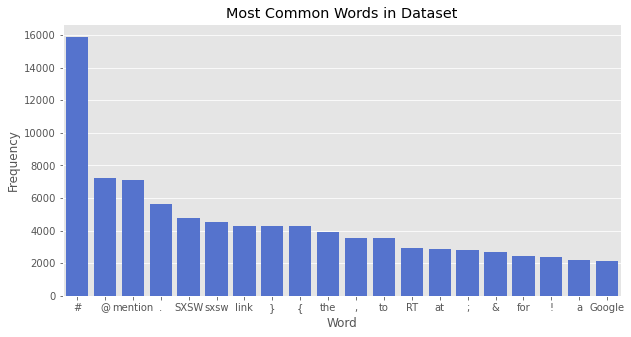

In [19]:
# visualize frequency distribution
top_20 = pd.DataFrame(unprocessed_freq_dist.most_common(20), columns=['token', 'freq'])
plt.figure(figsize=(10, 5))
sns.barplot(x=top_20['token'], y=top_20['freq'], color='royalblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words in Dataset')
plt.show()

From first glance, we can see a number of the top appearing words / tokens are stopwords or punctuation.  Not surprising given our dataset, we also see the most common tokens are related to twitter tweet structure, with `#` and `@` along with others standing out.

Before moving on with the data preparation stage, it will be helpful to understand the most common words in our dataset, excluding these unhelpful stopwords.  Remove stopwords, and reproduce frequency distributions by class label to see if any tokens start to stand out. 

## Stopwords

In [20]:
# set up initial stopwords list
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']
stopwords_list += ['mention', 'sxsw', 'link', 'rt', 'quot', 'google', 
                   'apple', 'iphone', 'android', 'ipad', 'ipad2', 
                   'store', 'app', 'new', "n't", "'s"]

We have leveraged stopwords from NLTK, but there are likely some words being included in this stoplist that we don't want removed from our tweets.  The best step to identify these, is to review the stopwords list, and manually remove any words that should not be included.

In [21]:
# preview stopwords list
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
# words that should be excluded from stopwords
drop_from_stopwords = ["against", "no", "nor", "no", "don't", "should",
                       "should've", "aren't", "couldn't", "doesn't", "hadn't",
                       "hasn't", "haven't", "isn't", "shan't", "shouldn't",
                       "wasn't", "weren't", "won't", "wouldn't", "wouldn",
                       "won", "weren", "wasn", "shouldn", "shan", "needn't", 
                       "needn", "mustn't", "mustn", "isn", "haven", "hasn",
                       "hadn", "doesn", "didn't", "didn", "couldn", "aren", "ain"]

# create new stopwords list exluding the above
stopwords_list = [word for word in stopwords_list if word not in drop_from_stopwords]

With the stopwords list setup, we can move forward with dropping stopwords from our tweets and reproducing frequency distributions to see the most common words.  It will also be helpful to compare the most common words for different sentiment class labels. 

In [23]:
# separate datasets based on class label
neutral_tweets = clean_df.loc[clean_df['sentiment'] == 'No emotion toward brand or product']
positive_tweets = clean_df.loc[clean_df['sentiment'] == 'Positive emotion']
negative_tweets = clean_df.loc[clean_df['sentiment'] == 'Negative emotion']
ambig_tweets = clean_df.loc[clean_df['sentiment'] == "I can't tell"]
all_tweets = clean_df.copy()

To make things easier, and to minimize the amount of code that needs to be reproduced below, I've written a few functions to help with the processing and visualization of tweet data.  These functions help produce the most frequent words, bigrams, and mutual information scores to help inform the modeling process. 

## Functions to Assist in EDA

In [24]:
def initial_tweet_process(tweet, stopwords_list):
    """
    Function to intially process a tweet to assist in EDA / data understanding. 
    Input: tweet of type string, stopwords_list of words to remove
    Returns: tokenized tweet, converted to lowercase, with all stopwords removed
    """
    # tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # remove stopwords and lowercase
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
    # return processed tweet
    return stopwords_removed

In [25]:
def concat_tweets(tweets):
    """
    Function to concatenate a list of tweets into one piece of text.
    Input: tweets (list of tweets)
    Returns: concatenated tweet string
    """
    tweets_concat = []
    for tweet in tweets:
        tweets_concat += tweet
    return tweets_concat

In [26]:
def process_concat(raw_text, stopwords_list):
    """
    Function to process and return concatenated tweets.  Takes raw text, and stopwords. 
    Returns: concatenated tweets
    """
    processed_text = raw_text.apply(lambda x: initial_tweet_process(x, stopwords_list))
    return concat_tweets(list(processed_text))

In [27]:
def print_normalized_word_freq(freq_dist, n=15):
    """
    Print a normalized frequency distribution from a given distribution. Returns top n results. 
    """
    total_word_count = sum(freq_dist.values())
    top = freq_dist.most_common(n)
    
    print('Word\t\t\tNormalized Frequency')
    for word in top:
        normalized_freq = word[1] / total_word_count
        print('{} \t\t\t {:.4}'.format(word[0], normalized_freq))
    
    return None

In [28]:
def print_bigrams(tweets_concat, n=15):
    """
    Function takes concatenated tweets and prints most common bigrams
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tweets_concat)
    tweet_scored = finder.score_ngrams(bigram_measures.raw_freq)
    display(tweet_scored[:n])
    return tweet_scored

In [29]:
def display_pmi(tweets_concat, freq_filter=10, n=15):
    """
    Function that takes concatenated tweets and a freq_filter number. Displays PMI scores. 
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    tweet_pmi_finder = BigramCollocationFinder.from_words(tweets_concat)
    tweet_pmi_finder.apply_freq_filter(freq_filter)
    tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)
    display(tweet_pmi_scored[:n])
    return tweet_pmi_scored

## Produce Additional Corpus Statistics
Now we will apply the functions written above to our separated datasets. This should help inform differences between tweets with different sentiment labels.  Hopefully, this starts to shed some light on which features may be helpful for text classification.

In [30]:
# process and concat datasets
concat_neutral = process_concat(neutral_tweets['text'], stopwords_list)
concat_positive = process_concat(positive_tweets['text'], stopwords_list)
concat_negative = process_concat(negative_tweets['text'], stopwords_list)
concat_ambig = process_concat(ambig_tweets['text'], stopwords_list)
concat_all = process_concat(all_tweets['text'], stopwords_list)

In [31]:
# produce freq dists
freqdist_neutral = nltk.FreqDist(concat_neutral)
freqdist_positive = nltk.FreqDist(concat_positive)
freqdist_negative = nltk.FreqDist(concat_negative)
freqdist_ambig = nltk.FreqDist(concat_ambig)
freqdist_all = nltk.FreqDist(concat_all)

In [32]:
# display top neutral words
print('Top Neutral Words')
neutral_top_15 = freqdist_neutral.most_common(15)
neutral_top_15

Top Neutral Words


[('austin', 631),
 ('amp', 601),
 ('2', 569),
 ('social', 481),
 ('launch', 478),
 ('today', 441),
 ('circles', 437),
 ('network', 357),
 ('called', 277),
 ('via', 271),
 ('line', 269),
 ('free', 260),
 ('pop-up', 249),
 ('party', 234),
 ('mobile', 231)]

In [33]:
# display top positive words
print('Top Positive Words')
positive_top_15 = freqdist_positive.most_common(15)
positive_top_15

Top Positive Words


[('2', 503),
 ('austin', 294),
 ('amp', 211),
 ('get', 174),
 ('launch', 169),
 ('pop-up', 151),
 ('one', 149),
 ('party', 146),
 ('line', 142),
 ('great', 137),
 ('time', 136),
 ('free', 125),
 ('social', 124),
 ('via', 120),
 ('cool', 120)]

In [34]:
# display negative words
print('Top Negative Words')
negative_top_15 = freqdist_negative.most_common(15)
negative_top_15

Top Negative Words


[('2', 65),
 ('like', 42),
 ('no', 41),
 ('need', 35),
 ('circles', 32),
 ('social', 31),
 ('apps', 30),
 ('people', 29),
 ('design', 28),
 ('ha', 28),
 ('wa', 26),
 ('get', 25),
 ('austin', 24),
 ('one', 23),
 ('amp', 22)]

In [35]:
print('Top Ambiguous Words')
ambig_top_15 = freqdist_ambig.most_common(15)
ambig_top_15

Top Ambiguous Words


[('2', 19),
 ('austin', 16),
 ('circles', 16),
 ('social', 12),
 ('like', 11),
 ('go', 10),
 ('pop-up', 9),
 ('product', 9),
 ('line', 9),
 ('today', 8),
 ('via', 8),
 ('game', 8),
 ('network', 7),
 ('called', 7),
 ('think', 7)]

In [36]:
# display top all 
print('Top Words from All Tweets')
all_top_15 = freqdist_all.most_common(15)
all_top_15

Top Words from All Tweets


[('2', 1156),
 ('austin', 965),
 ('amp', 836),
 ('launch', 675),
 ('social', 648),
 ('circles', 591),
 ('today', 580),
 ('network', 472),
 ('line', 440),
 ('get', 425),
 ('pop-up', 422),
 ('via', 413),
 ('party', 390),
 ('free', 387),
 ('called', 361)]

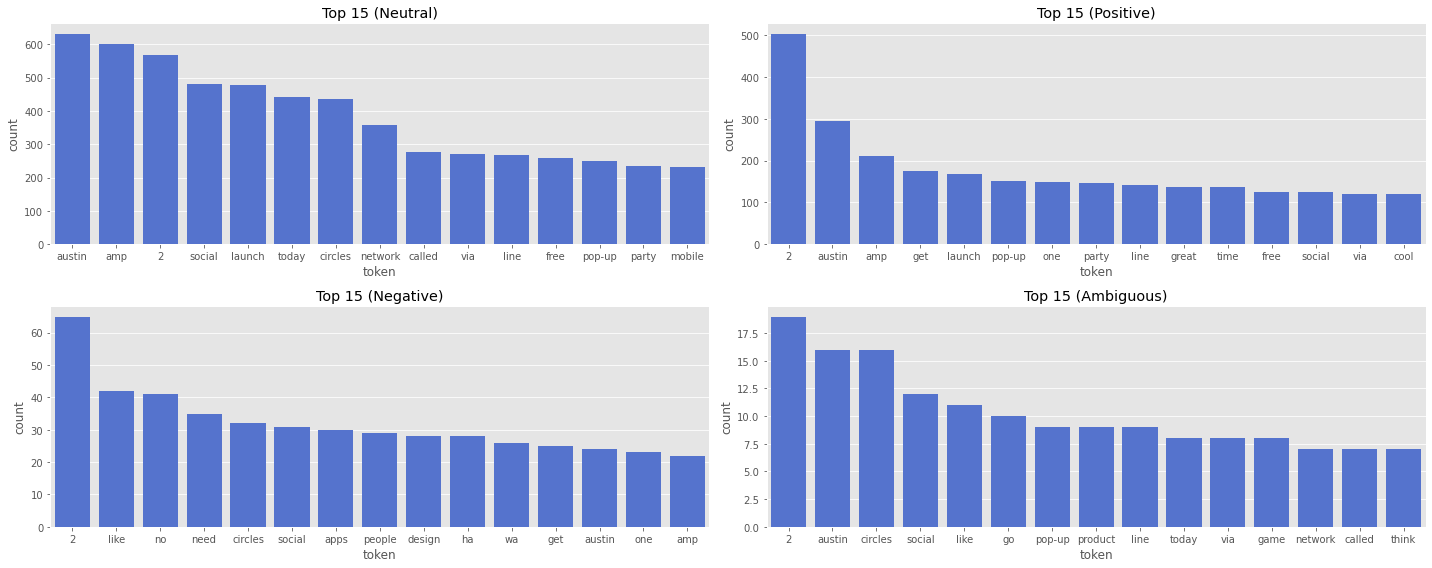

In [37]:
# visualize with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
freq_dists = [neutral_top_15, positive_top_15, negative_top_15, ambig_top_15]
labels = ['Top 15 (Neutral)', 'Top 15 (Positive)', 'Top 15 (Negative)', 'Top 15 (Ambiguous)']
for idx, ax in enumerate(axes.flat):
    sns.barplot(data=pd.DataFrame(freq_dists[idx], columns=['token', 'count']),
                x='token',
                y='count',
                ax=ax,
                color='royalblue')
    ax.set_title(labels[idx])
plt.tight_layout()

Comparing the top words by class label, we start to see that positive and neutral tweets actually share many of the same tokens.  There are some differences starting to show.  For example, `free` and`great` are within the top 15 of positive tweets, but not within the top 15 of negative tweets. 

Move forward with producing bigrams - looking at word pairings may provide additioanl insight the top tokens does not provide.

In [38]:
# print bigrams
print('Neutral Bigrams:')
neutral_bigrams = print_bigrams(concat_neutral)

print('Positive Bigrams')
positive_bigrams = print_bigrams(concat_positive)

print('Negative Bigrams')
negative_bigrams = print_bigrams(concat_negative)

print('Ambiguous Bigrams')
ambig_bigrams = print_bigrams(concat_ambig)

Neutral Bigrams:


[(('social', 'network'), 0.00778593162699123),
 (('called', 'circles'), 0.005705208519778056),
 (('network', 'called'), 0.005638088419545374),
 (('major', 'social'), 0.005034007517451226),
 (('launch', 'major'), 0.004855020583497405),
 (('possibly', 'today'), 0.0041614462144263465),
 (('circles', 'possibly'), 0.0041390728476821195),
 (('downtown', 'austin'), 0.0026176839090746376),
 (('marissa', 'mayer'), 0.0024610703418650438),
 (('2', 'launch'), 0.0018569894397708966),
 (('opening', 'temporary'), 0.001700375872561303),
 (('pop-up', 'austin'), 0.001566135672095937),
 (('austin', '2'), 0.0013871487381421157),
 (('temporary', 'downtown'), 0.0013871487381421157),
 (('launch', 'social'), 0.0012081618041882942)]

Positive Bigrams


[(('social', 'network'), 0.003408505410011494),
 (('downtown', 'austin'), 0.0028536324362886923),
 (('network', 'called'), 0.002259125678728548),
 (('called', 'circles'), 0.002219491894891205),
 (('marissa', 'mayer'), 0.002219491894891205),
 (('2', 'launch'), 0.0021402243272165195),
 (('launch', 'major'), 0.0021402243272165195),
 (('major', 'social'), 0.0021402243272165195),
 (('opening', 'temporary'), 0.001704252705005747),
 (('possibly', 'today'), 0.001624985137331061),
 (('circles', 'possibly'), 0.001585351353493718),
 (('temporary', 'downtown'), 0.001506083785819032),
 (('no', 'one'), 0.0014664500019816891),
 (('even', 'begins'), 0.0014268162181443461),
 (('cool', 'technology'), 0.0013475486504696604)]

Negative Bigrams


[(('social', 'network'), 0.002699575780948708),
 (('news', 'apps'), 0.002506748939452372),
 (('fascist', 'company'), 0.0023139220979560356),
 (('major', 'social'), 0.0023139220979560356),
 (('called', 'circles'), 0.0021210952564596993),
 (('network', 'called'), 0.0021210952564596993),
 (('company', 'america'), 0.0019282684149633628),
 (('design', 'headaches'), 0.0019282684149633628),
 (('launch', 'major'), 0.0019282684149633628),
 (('apps', 'fade'), 0.0017354415734670266),
 (('fade', 'fast'), 0.0017354415734670266),
 (('fast', 'among'), 0.0017354415734670266),
 (('novelty', 'news'), 0.0017354415734670266),
 (("'ve", 'heard'), 0.0015426147319706903),
 (('2', 'money'), 0.0015426147319706903)]

Ambiguous Bigrams


[(('social', 'network'), 0.005255255255255256),
 (('called', 'circles'), 0.0045045045045045045),
 (('network', 'called'), 0.0045045045045045045),
 (('circles', 'possibly'), 0.003003003003003003),
 (('launch', 'social'), 0.003003003003003003),
 (("'re", 'going'), 0.0015015015015015015),
 (('2', 'austin'), 0.0015015015015015015),
 (('ai', 'profile'), 0.0015015015015015015),
 (('another', 'one'), 0.0015015015015015015),
 (('austin', 'via'), 0.0015015015015015015),
 (('barry', 'diller'), 0.0015015015015015015),
 (('becomes', 'ai'), 0.0015015015015015015),
 (('circles', '______'), 0.0015015015015015015),
 (('control', 'identity'), 0.0015015015015015015),
 (('facebook', 'becomes'), 0.0015015015015015015)]

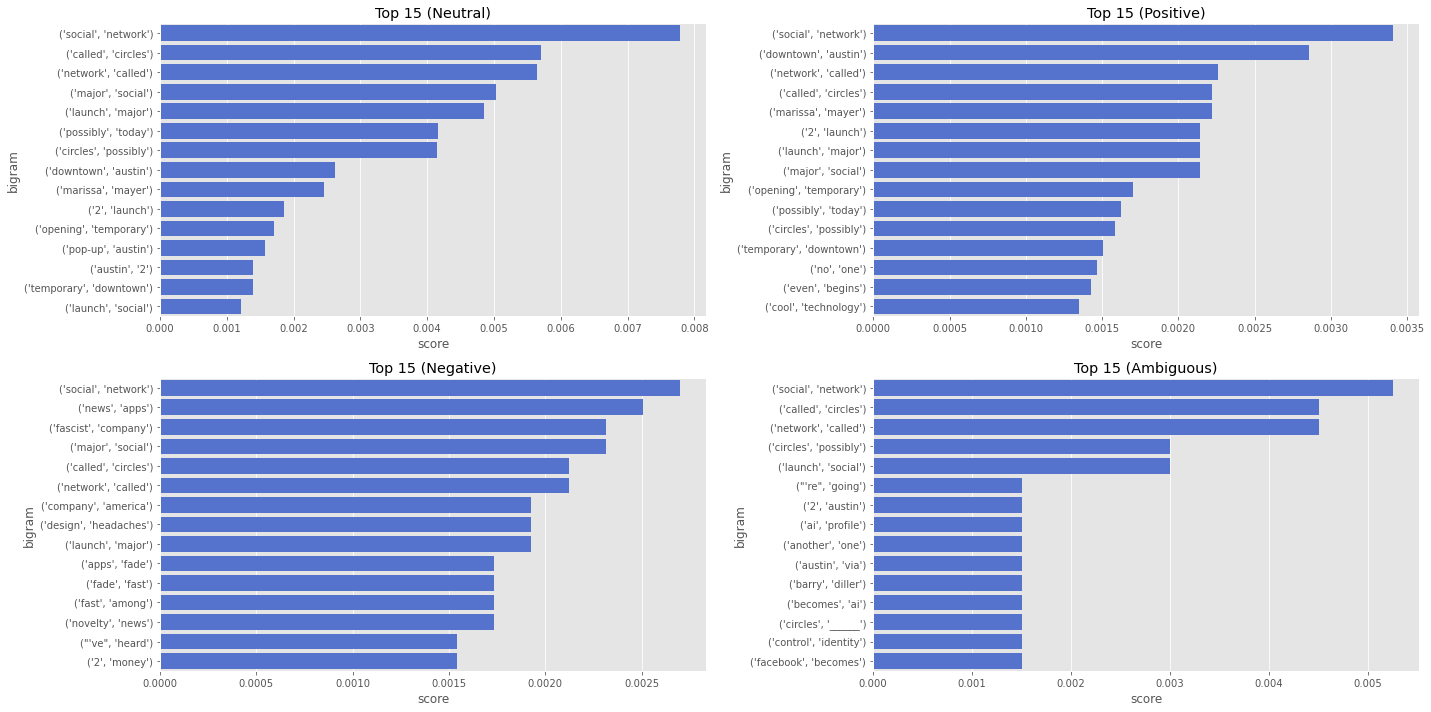

In [39]:
# pull out top n bigrams
top_n = 15
top_neutral_bigrams = pd.DataFrame(neutral_bigrams[:top_n], columns=['bigram', 'score'])
top_positive_bigrams = pd.DataFrame(positive_bigrams[:top_n], columns=['bigram', 'score'])
top_negative_bigrams = pd.DataFrame(negative_bigrams[:top_n], columns=['bigram', 'score'])
top_ambig_bigrams = pd.DataFrame(ambig_bigrams[:top_n], columns=['bigram', 'score'])

# visualize
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
bigrams = [top_neutral_bigrams, top_positive_bigrams, top_negative_bigrams, top_ambig_bigrams]
labels = ['Top 15 (Neutral)', 'Top 15 (Positive)', 'Top 15 (Negative)', 'Top 15 (Ambiguous)']
for idx, ax in enumerate(axes.flat):
    sns.barplot(data=bigrams[idx],
                y='bigram',
                x='score',
                ax=ax,
                color='royalblue')
    ax.set_title(labels[idx])
plt.tight_layout()

Reviewing the top bigrams for each class, we see similarities to the token frequency distribution.  There are shared common pairings for each class, but again, we are starting to see differences emerge between the positive and negative tweets:
* Standouts in the positive tweets include: (launch, major) and (cool, technology)
* Standouts in the negative tweets include: (design, headaches) and (fascist, company)

Move forward with pointwise mutual information scores to try and find additional insight. 

In [40]:
# print PMI scores
print('Neutral PMI:')
neutral_pmi = display_pmi(concat_neutral)
print('Positive PMI:')
positive_pmi = display_pmi(concat_positive)
print('Negative PMI:')
negative_pmi = display_pmi(concat_negative)

Neutral PMI:


[(('lonely', 'planet'), 11.988426486316731),
 (('speak.', 'mark'), 11.988426486316731),
 (('speech', 'therapy'), 11.747418386812937),
 (('augmented', 'reality'), 11.640503182896424),
 (('therapy', 'communication'), 11.609914863063002),
 (('communication', 'showcased'), 11.54096750934551),
 (('dwnld', 'groundlink'), 11.54096750934551),
 (('mark', 'belinsky'), 11.50299965914649),
 (('barry', 'diller'), 11.44785810495403),
 (('league', 'extraordinary'), 11.447858104954026),
 (('social-type', 'rewards'), 11.277933103511717),
 (('south', 'southwest'), 11.125930010066666),
 (('mike', 'tyson'), 11.125930010066664),
 (('exhibit', 'hall'), 11.05554068217527),
 (('interrupt', 'regularly'), 11.055540682175268)]

Positive PMI:


[(('speak.', 'mark'), 11.03794726573905),
 (('belinsky', '911tweets'), 10.912416383655192),
 (('mark', 'belinsky'), 10.912416383655192),
 (('holler', 'gram'), 10.622909766460207),
 (('physical', 'worlds'), 10.59048828876783),
 (('gon', 'na'), 10.535446925209865),
 (('choice', 'awards'), 10.300981671572842),
 (('convention', 'center'), 10.255339006017131),
 (('includes', 'uberguide'), 10.163478147822909),
 (('ubersocial', 'includes'), 10.093088819931511),
 (('connect', 'digital'), 9.908664248794082),
 (('uberguide', 'sponsored'), 9.690023962318744),
 (('song', 'info'), 9.600541953431753),
 (('core', 'action'), 9.50051313510048),
 (('looking', 'forward'), 9.365521923767556)]

Negative PMI:


[(('fascist', 'company'), 8.310659147459244),
 (('company', 'america'), 8.270017162961896),
 (('network', 'called'), 8.01193555009916),
 (('design', 'headaches'), 7.53305156879569),
 (('launch', 'major'), 7.395548045045755),
 (('major', 'social'), 7.163817759129973),
 (('social', 'network'), 7.106102261273685),
 (('called', 'circles'), 7.099398391349499),
 (('news', 'apps'), 6.964030611943556)]

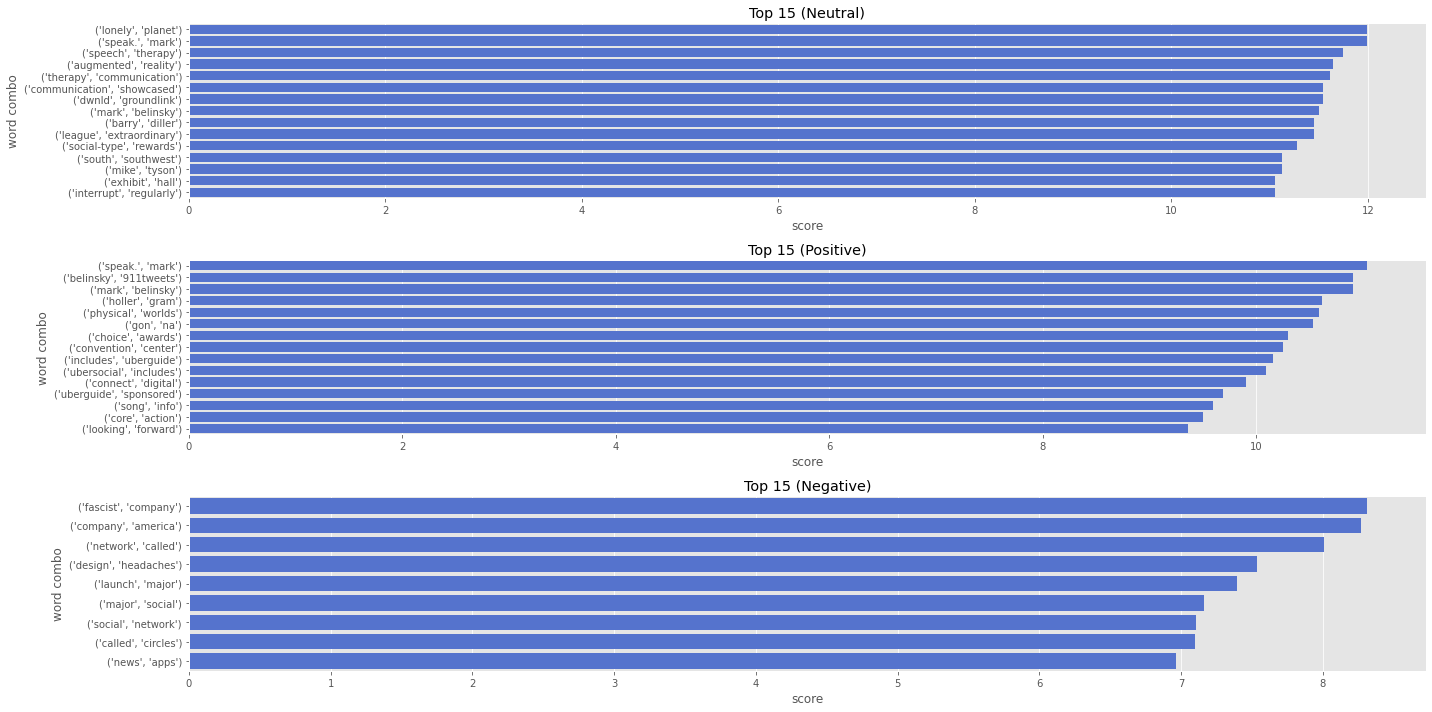

In [41]:
# pull out top n pmi scores
top_n = 15
top_neutral_pmi = pd.DataFrame(neutral_pmi[:top_n], columns=['word combo', 'score'])
top_positive_pmi = pd.DataFrame(positive_pmi[:top_n], columns=['word combo', 'score'])
top_negative_pmi = pd.DataFrame(negative_pmi[:top_n], columns=['word combo', 'score'])

# visualize
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
pmis = [top_neutral_pmi, top_positive_pmi, top_negative_pmi]
labels = ['Top 15 (Neutral)', 'Top 15 (Positive)', 'Top 15 (Negative)', 'Top 15 (Ambiguous)']
for idx, ax in enumerate(axes.flat):
    sns.barplot(data=pmis[idx],
                y='word combo',
                x='score',
                ax=ax,
                color='royalblue')
    ax.set_title(labels[idx])
plt.tight_layout()

PMI makes use of bigrams.  PMI is a statistical measure from information theory that generally measures the mutual dependence between two words.  This means, PMI is measuring how much information the bigram itself contains by computing the dependence between the two words in the bigram. 

Looking at PMI scores, we can see some further trends standing out.  Some word combinations within the positive dataset that stand out include: (choice, awards), (uberguide, sponsored), (looking, forward).  Some word combinations that stood out within the negative set included: (fascist, company) and (design, headaches).  

Now that we have a good sense of our data and the distribution, we can move on to the data preparation phase

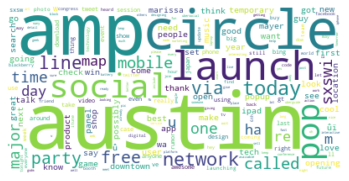

In [42]:
# generate wordcloud for all tweets
from wordcloud import WordCloud
word_cloud_text = " ".join(concat_all)
word_cloud = WordCloud(collocations=False, background_color='white').generate(word_cloud_text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [43]:
# generate wordcloud for positive and negative tweets
word_cloud_positive = " ".join(concat_positive)
word_cloud_negative = " ".join(concat_negative)
neg_word_cloud = WordCloud(collocations=False, 
                           background_color='white').generate(word_cloud_positive)
pos_word_cloud = WordCloud(collocations=False, 
                           background_color='white').generate(word_cloud_negative)

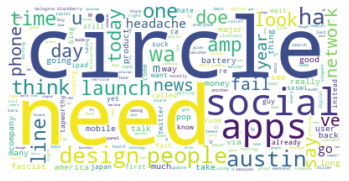

In [44]:
# positive word cloud
plt.imshow(pos_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

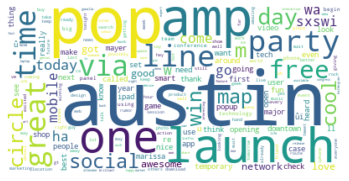

In [45]:
# negative word cloud
plt.imshow(neg_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 3. Data Preparation
Leverage information learned during data understanding phase to preprocess dataset and prepare data for modeling. 

In [46]:
# set seed for reproducibility
SEED = 1

In [47]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [48]:
# pull in copy of dataset
clean_df = raw_df.copy()

# relabel columns
clean_df.columns = ['text', 'product_brand', 'sentiment']

# drop product_brand column, handle missing values and duplicates
clean_df = clean_df.drop('product_brand', axis=1)
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()

# remove ambiguous tweets
clean_df = clean_df.loc[clean_df['sentiment'] != "I can't tell"]

In [49]:
# separate dataset into text and class_labels
text = clean_df['text']
class_labels = clean_df['sentiment']

In [50]:
# split tweets and labels into train and test sets for validation purposes
X_train, X_test, y_train, y_test = train_test_split(text, 
                                                    class_labels, 
                                                    stratify=class_labels, # keep target split
                                                    random_state=SEED)

In [51]:
# pull in updated stopwords
updated_stopwords = stopwords_list.copy()

In [52]:
def preprocess_tweet(tweet, stopwords_list):
    """
    Function to preprocess a tweet. 
    Takes: tweet, stopwords list
    Returns: processed tweet with stopwords removed, lemmatized, and converted to lowercase
    """
    # remove apostrophes and excess white space
    processed = re.sub("\'", '', tweet) 
    processed = re.sub('\s+', ' ', processed)
    
    # tokenize tweet
    tokens = nltk.word_tokenize(processed) # tokenize
    
    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    stopwords_removed = [token.lower() for token in lemmatized_tokens if token.lower() not in stopwords_list]
    return ' '.join(stopwords_removed)

In [53]:
# preprocess train and test sets
X_train_preprocessed = X_train.apply(lambda x: preprocess_tweet(x, updated_stopwords))
X_test_preprocessed = X_test.apply(lambda x: preprocess_tweet(x, updated_stopwords))

Now that we have split our data into train and test sets, as well as, preprocessed both train and test sets, we are ready to vectorize our data.  We expect TF-IDF vectorizer to work better for text classification given inverse document frequency, but we will move forward with comparing multiple vectorization strategies.

In [54]:
# create vectorizers with unigram and bigrams
count_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word') # use unigrams and ngrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='word') # use unigrams and ngrams

# fit to preprocessed data
X_train_count = count_vectorizer.fit_transform(X_train_preprocessed)
X_test_count = count_vectorizer.transform(X_test_preprocessed) 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_preprocessed) 
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed) 

### Word Embeddings
For this project, I load the pretrained weights from GloVe (Global Vectors for Word Representation) from the Standford NLP Group.  These are commonly accepted as some of the best pre-trained word vectors available.  For more information please visit https://nlp.stanford.edu/projects/glove/

The file we will be using is called `glove.6B.50d.txt`, and contains 50-dimensional word vectors for 6 billion words. 

We don't need all vectors in this file, however.  We only need the vectors for the words that appear in the dataset.  For this reason, the total vocabulary size is calculated below.

In [55]:
# tokenize datasets
tokenized_X_train = X_train_preprocessed.map(nltk.word_tokenize).values
tokenized_X_test = X_test_preprocessed.map(nltk.word_tokenize).values

# get total training vocabulary size
total_train_vocab = set(word for tweet in tokenized_X_train for word in tweet)
train_vocab_size = len(total_train_vocab)
print(f'There are {train_vocab_size} unique tokens in the processed training set.')

There are 8582 unique tokens in the processed training set.


With the total vocabulary, we can get the appropriate vectors out of the GloVe file with the below code:

In [56]:
def glove_vectors(vocab):
    """
    Returns appropriate vectors from GloVe file.
    Input: vocabulary set to use.
    """
    glove = {}
    with open('data/glove.6B.50d.txt', 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
    return glove

In [57]:
glove = glove_vectors(total_train_vocab)

Running the cell above will give all the of the words and their corresponding vectors of the vocabulary stored within the dictionary, `glove`, as key/value pairs.

Can double check everything worked by getting the vector for a word from the `glove` dictionary.  We know from above that the word `party` appears. 

In [60]:
# check that things worked, by getting the vector
glove['party']

array([-5.5270e-01, -1.8334e-01,  4.1146e-01,  1.8710e-01,  3.2366e-01,
        8.1401e-01, -2.5834e-01, -3.7991e-02, -1.2893e+00, -6.9391e-01,
       -4.3524e-01, -8.4417e-01, -4.4350e-01,  8.1766e-01, -4.2273e-01,
       -2.5819e-01,  2.2241e-01, -2.4498e-01,  7.4857e-01, -1.8836e-01,
       -2.0798e-01, -1.0965e-01,  4.3051e-01,  3.4885e-01,  4.7003e-03,
       -1.8722e+00, -4.5693e-01, -5.9019e-01, -1.0799e+00,  8.9101e-01,
        3.2906e+00,  6.0932e-01, -1.8394e+00, -1.3930e-03, -1.2088e+00,
       -5.4240e-01, -2.0398e-01, -1.0650e-02, -4.7815e-01, -3.5888e-01,
       -4.3413e-01,  1.0943e-01, -1.5387e+00, -1.0608e-01, -3.0507e-01,
        1.3978e-03, -1.9332e+00, -4.2890e-01,  1.0175e+00, -5.9931e-01],
      dtype=float32)

Now that we have the word vectors for every word in the dataset, we can combine all the vectors for a given tweet into a Mean Embedding by finding the average of all the vectors in that tweet. 

In [61]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Now that we have created a mean vectorizer class, we can use this to vectorize our data. 

In [63]:
# instantiate vectorizer objects with glove
w2v_vectorizer = W2vVectorizer(glove)

# transform training and testing data
X_train_w2v = w2v_vectorizer.transform(tokenized_X_train)
X_test_w2v = w2v_vectorizer.transform(tokenized_X_test)

Now that we have vectorized our datasets, we are ready to move on to the modeling stage.

# 4. Modeling

This is a classification task, tasked with classifying the sentiment of tweets based on the text within the tweet. Three primary models will be relied on for classification:
1. Random Forests
2. Linear SVM
3. Neural Networks

Overfitting will be addressed thru hyperparameter tuning and dropout layers in the case of neural networks.  

This is a multi-class classification problem, with three available class labels (Neutral, Positive, or Negative). As a result, the performance metric we will focus on throughout this process will be accuracy. We are not too concerned about the ramifications of false positives or false negatives.  For this reason accuracy will be our selected perforamnce metric.

### Random Forest

In [60]:
# instantiate random forest classifiers, with balanced class_weight
rf_count = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced')
rf_tfidf = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced')
rf_w2v = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced')

# fit to training sets
rf_count.fit(X_train_count, y_train)
rf_tfidf.fit(X_train_tfidf, y_train)
rf_w2v.fit(X_train_w2v, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [61]:
# Count Vectorized
count_train_score = rf_count.score(X_train_count, y_train)
count_test_score = rf_count.score(X_test_count, y_test)
print(f'Count Vectorized Train Score: {count_train_score}')
print(f'Count Vectorized Test Score: {count_test_score}')
print('--------')

# TF-IDF Vectorized
tfidf_train_score = rf_tfidf.score(X_train_tfidf, y_train)
tfidf_test_score = rf_tfidf.score(X_test_tfidf, y_test)
print(f'TF-IDF Vectorized Train Score: {tfidf_train_score}')
print(f'TF-IDF Vectorized Test Score: {tfidf_test_score}')
print('--------')

# W2V Vectorized
w2v_train_score = rf_w2v.score(X_train_w2v, y_train)
w2v_test_score = rf_w2v.score(X_test_w2v, y_test)
print(f'Word2Vec Vectorized Train Score: {w2v_train_score}')
print(f'Word2Vec Vectorized Test Score: {w2v_test_score}')

Count Vectorized Train Score: 0.9603590127150337
Count Vectorized Test Score: 0.6855091969493046
--------
TF-IDF Vectorized Train Score: 0.9603590127150337
TF-IDF Vectorized Test Score: 0.6742934051144011
--------
Word2Vec Vectorized Train Score: 0.9543754674644727
Word2Vec Vectorized Test Score: 0.6500672947510094


Reviewing baseline random model scores for our three vectorized datasets (count, tf-idf, and word2vec using glove), we can see that results are fairly consistent across our vectorization methods. Further, looking at our high training set accuracy score vs. test scores, shows we are likely overfitting slightly to the training data.  

Address overfitting thru hyperparameter tuning. 

#### Random Forest - Count Vectorized
Tune hyperparams with grid search

In [62]:
# set params
grid_search_params = {
    'min_samples_split': [4, 5],
    'min_samples_leaf': [3, 4],
    'max_depth': [25, 50, 75],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['entropy', 'gini']
}

# instantiate classifier
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=SEED, class_weight='balanced', n_estimators=100)

# instantiate grid search
rf_gs_count = GridSearchCV(estimator=rf_classifier, 
                           param_grid=grid_search_params, 
                           cv=3, 
                           scoring='accuracy', 
                           return_train_score=True,
                           verbose=1)

In [63]:
# fit to count vectorized
rf_gs_count.fit(X_train_count, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [25, 50, 75],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [64]:
# print count-vectorized results
mean_train_score_count = np.mean(rf_gs_count.cv_results_['mean_train_score'])
mean_test_score_count = np.mean(rf_gs_count.cv_results_['mean_test_score'])
print(f'Random Search Train Accuracy (Count Vect.): {mean_train_score_count}')
print(f'Random Search Test Accuracy (Count Vect.): {mean_test_score_count}')

# display best params
rf_gs_count.best_params_

Random Search Train Accuracy (Count Vect.): 0.6533561168995164
Random Search Test Accuracy (Count Vect.): 0.564169325075575


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4}

We have successfully addressed overfitting, as evidenced by closeness of training and testing accuracy. Fit model with these params and reprint training and testing scores. 

In [65]:
# run best count-vect model with these params
best_rf_count = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=SEED,
                                       bootstrap=True,
                                       criterion='gini',
                                       max_depth=75,
                                       max_features='auto',
                                       min_samples_leaf=3,
                                       min_samples_split=4)

# fit to count vect data
best_rf_count.fit(X_train_count, y_train)

# print testing score
print(f'Best Tuned Random Forest (Count Vectorized) Test Accuracy: {best_rf_count.score(X_test_count, y_test)}')
print(f'Best Tuned Random Forest (Count Vectorized) Train Accuracy: {best_rf_count.score(X_train_count, y_train)}')

Best Tuned Random Forest (Count Vectorized) Test Accuracy: 0.5939883355764917
Best Tuned Random Forest (Count Vectorized) Train Accuracy: 0.6824233358264772


Looking at the best identified tuned random forest model on our count vectorized data, we see overfitting has largely been addressed, but model performance is not looking great with testing accuracy scores coming in close to 59%.

#### Random Forest - TF-IDF Vectorized

Use grid search to tune params.  Still need to address overfitting identified in baseline models.

In [66]:
# similar to count vectorized, run refined grid search and try to further address overfitting
grid_search_params = {
    'min_samples_split': [4, 5],
    'min_samples_leaf': [3, 4],
    'max_depth': [25, 50, 75],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['entropy', 'gini']
}

# instantiate classifier
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=SEED, class_weight='balanced', n_estimators=100)

# instantiate grid search
rf_gs_tfidf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=grid_search_params, 
                           cv=3, 
                           scoring='accuracy', 
                           return_train_score=True,
                           verbose=1)

In [67]:
# fit to training data
rf_gs_tfidf.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [25, 50, 75],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [68]:
# print search results
mean_train_score_tfidf = np.mean(rf_gs_tfidf.cv_results_['mean_train_score']) 
mean_test_score_tfidf = np.mean(rf_gs_tfidf.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy (TF-IDF): {mean_train_score_tfidf}')
print(f'Grid Search Test Accuracy (TF-IDF): {mean_test_score_tfidf}')

# display best params
rf_gs_tfidf.best_params_

Grid Search Train Accuracy (TF-IDF): 0.6764298649179623
Grid Search Test Accuracy (TF-IDF): 0.5612460960632011


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4}

Similar to count vectorized data, we see overfitting has been addressed through tuning of hyperparams.  Move forward with fitting a model with these params and refitting to training data. 

In [69]:
# run best tfidf model with identified params
best_rf_tfidf = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced', n_estimators=100,
                                       min_samples_split=4, 
                                       min_samples_leaf=3,
                                       max_depth=75,
                                       max_features='auto',
                                       bootstrap=True,
                                       criterion='gini')

# fit to tfidf vectorized
best_rf_tfidf.fit(X_train_tfidf, y_train)

# print testing score
print(f'Best Tuned Random Forest (TF-IDF Vectorized) Test Accuracy: {best_rf_tfidf.score(X_test_tfidf, y_test)}')
print(f'Best Tuned Random Forest (TF-IDF Vectorized) Train Accuracy: {best_rf_tfidf.score(X_train_tfidf, y_train)}')

Best Tuned Random Forest (TF-IDF Vectorized) Test Accuracy: 0.6007178106774338
Best Tuned Random Forest (TF-IDF Vectorized) Train Accuracy: 0.7080029917726253


Looking at the best identified tuned random forest results on the TF-IDF vectorized dataset, we can see results are similar to those seen with count vectorized data.  Although we have addressed overfitting to training data that was present in our baselines, accuracy scores are still hovering around 60%. Move forward with next vectorization strategy

#### Random Forest - Word2Vec Vectorized

In [70]:
# further refine with grid search and further address overfitting
rf_params_w2v = {
    'min_samples_split': [5, 6],
    'min_samples_leaf': [3, 4],
    'max_depth': [3, 4, 5],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['entropy', 'gini']
}

# instantiate classifier
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=SEED, class_weight='balanced', n_estimators=100)

# instantiate grid search
rf_gs_w2v = GridSearchCV(estimator=rf_classifier, 
                           param_grid=rf_params_w2v, 
                           cv=3, 
                           scoring='accuracy', 
                           return_train_score=True,
                           verbose=1)

In [71]:
rf_gs_w2v.fit(X_train_w2v, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [5, 6]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [72]:
# print word2vec vectorized grid search results
mean_train_score_w2v = np.mean(rf_gs_w2v.cv_results_['mean_train_score']) 
mean_test_score_w2v = np.mean(rf_gs_w2v.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy (word2vec): {mean_train_score_w2v}')
print(f'Grid Search Test Accuracy (word2vec): {mean_test_score_w2v}')

# display best params
rf_gs_w2v.best_params_

Grid Search Train Accuracy (word2vec): 0.5511777914554757
Grid Search Test Accuracy (word2vec): 0.4880267143247208


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5}

While overfitting has been addressed, overall model performance is notably worse than count and TF-IDF vectorized data.  Save a version of this as the best random forest we saw with w2v.  Given low performance, this model will most likely not be selected. 

In [73]:
# fit model using best found params for w2v data
best_rf_w2v = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_jobs=-1,
                                     n_estimators=75, bootstrap=True, criterion='gini', 
                                     max_depth=5, max_features='auto', min_samples_leaf=3, 
                                     min_samples_split=5)

best_rf_w2v.fit(X_train_w2v, y_train)

# print testing score
print(f'Best Tuned Random Forest (Word2Vec) Test Accuracy: {best_rf_w2v.score(X_test_w2v, y_test)}')
print(f'Best Tuned Random Forest (Word2Vec) Train Accuracy: {best_rf_w2v.score(X_train_w2v, y_train)}')

Best Tuned Random Forest (Word2Vec) Test Accuracy: 0.4988784208165096
Best Tuned Random Forest (Word2Vec) Train Accuracy: 0.5887808526551982


Using our word2vec vectorized data, we can see that overfitting has largely been addressed, but results are weaker than both count and TF-IDF vectorized data, with testing accuracy coming in around ~50%.  

### Linear SVM

Move on to modeling with LinearSVC classifier.  

In [74]:
# create linear SVC
svc_count = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=5000)
svc_tfidf = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=5000)
svc_w2v = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=5000)

# fit to training sets
svc_count.fit(X_train_count, y_train)
svc_tfidf.fit(X_train_tfidf, y_train)
svc_w2v.fit(X_train_w2v, y_train)

LinearSVC(class_weight='balanced', max_iter=5000, random_state=1)

In [75]:
# Count Vectorized
count_train_score = svc_count.score(X_train_count, y_train)
count_test_score = svc_count.score(X_test_count, y_test)
print(f'Count Vectorized Train Score: {count_train_score}')
print(f'Count Vectorized Test Score: {count_test_score}')
print('-----')

# TF-IDF Vectorized
tfidf_train_score = svc_tfidf.score(X_train_tfidf, y_train)
tfidf_test_score = svc_tfidf.score(X_test_tfidf, y_test)
print(f'TF-IDF Vectorized Train Score: {tfidf_train_score}')
print(f'TF-IDF Vectorized Test Score: {tfidf_test_score}')
print('-----')

# Word2Vec Vectorized
w2v_train_score = svc_w2v.score(X_train_w2v, y_train)
w2v_test_score = svc_w2v.score(X_test_w2v, y_test)
print(f'Word2Vect Vectorized Train Score: {w2v_train_score}')
print(f'Word2Vect Vectorized Test Score: {w2v_test_score}')

Count Vectorized Train Score: 0.9602094240837696
Count Vectorized Test Score: 0.6819201435621355
-----
TF-IDF Vectorized Train Score: 0.9542258788332086
TF-IDF Vectorized Test Score: 0.6859578286227007
-----
Word2Vect Vectorized Train Score: 0.5941660433807031
Word2Vect Vectorized Test Score: 0.5890533871691341


Looking at baseline LinearSVC results we can see that, similar to initial random forest models, we are overfitting to training data, except with word2vec vectorized data.  Move forward with hyperparameter tuning to try and improve results / address overfitting

#### LinearSVC - Count Vectorized

In [76]:
# set params for grid search
svc_params = {
    'C': [0.00001, 0.0001, .001],
    'loss': ['hinge', 'squared_hinge']
}

In [77]:
# grid search 
svc_classifier = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=10000)
svc_gs_count = GridSearchCV(svc_classifier,
                            svc_params,
                            return_train_score=True,
                            scoring='accuracy',
                            verbose=1)

In [78]:
# fit to training data
svc_gs_count.fit(X_train_count, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=LinearSVC(class_weight='balanced', max_iter=10000,
                                 random_state=1),
             param_grid={'C': [1e-05, 0.0001, 0.001],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [79]:
# print count-vectorized grid-search results
mean_train_score_count = np.mean(svc_gs_count.cv_results_['mean_train_score'])
mean_test_score_count = np.mean(svc_gs_count.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy (Count Vect.): {mean_train_score_count}')
print(f'Grid Search Test Accuracy (Count Vect.): {mean_test_score_count}')

# display best params
svc_gs_count.best_params_

Grid Search Train Accuracy (Count Vect.): 0.6212166542009475
Grid Search Test Accuracy (Count Vect.): 0.6102468212415856


{'C': 0.001, 'loss': 'squared_hinge'}

Through tuning, we have addressed overfitting, move forward with fitting a model with the identified params and fit to full training set.

In [80]:
# best count svc
best_svc_count = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=10000,
                           C=0.001, loss='squared_hinge')

best_svc_count.fit(X_train_count, y_train)

# print testing score
print(f'Best Tuned Linear SVC (Count) Test Accuracy: {best_svc_count.score(X_test_count, y_test)}')
print(f'Best Tuned Linear SVC (Count) Train Accuracy: {best_svc_count.score(X_train_count, y_train)}')

Best Tuned Linear SVC (Count) Test Accuracy: 0.6563481381785554
Best Tuned Linear SVC (Count) Train Accuracy: 0.7136873597606582


Best identified LinearSVC test accuracy coming in around 66%, and training accuracy around 71%. Fairly strong results with quick runtimes.  Strong contender for best model so far. 

#### Linear SVC (TF-IDF)

In [81]:
# failing to converge, try with tfidf vectorized data
# set params
svc_params = {
    'C': [0.0001, .001, 0.01],
    'loss': ['hinge', 'squared_hinge']
}

# grid search 
svc_classifier = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=10000)
svc_gs_tfidf = GridSearchCV(svc_classifier,
                            svc_params,
                            return_train_score=True,
                            scoring='accuracy')

svc_gs_tfidf.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=LinearSVC(class_weight='balanced', max_iter=10000,
                                 random_state=1),
             param_grid={'C': [0.0001, 0.001, 0.01],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='accuracy')

In [82]:
# print tfidf-vectorized grid search results
mean_train_score_tfidf = np.mean(svc_gs_tfidf.cv_results_['mean_train_score']) 
mean_test_score_tfidf = np.mean(svc_gs_tfidf.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy (TF-IDF): {mean_train_score_tfidf}')
print(f'Grid Search Test Accuracy (TF-IDF): {mean_test_score_tfidf}')

# display best params
svc_gs_tfidf.best_params_

Grid Search Train Accuracy (TF-IDF): 0.649507604088756
Grid Search Test Accuracy (TF-IDF): 0.6140613313388182


{'C': 0.01, 'loss': 'hinge'}

Again given similarities in testing and training data, we have likely addressed overfitting.  However, results are not looking great, especially when compared to strong results seen from count vectorized data. 

In [83]:
# fit best svc for tfidf
best_svc_tfidf = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=10000,
                           C=0.01, loss='squared_hinge')

best_svc_tfidf.fit(X_train_tfidf, y_train)

# print testing score
print(f'Best Tuned Linear SVC (TF-IDF) Test Accuracy: {best_svc_tfidf.score(X_test_tfidf, y_test)}')
print(f'Best Tuned Linear SVC (TF-IDF) Train Accuracy: {best_svc_tfidf.score(X_train_tfidf, y_train)}')

Best Tuned Linear SVC (TF-IDF) Test Accuracy: 0.6262898160610139
Best Tuned Linear SVC (TF-IDF) Train Accuracy: 0.6264771877337323


Best identified Linear SVC with TF-IDF vectorization found testing score around 62% and training score around 62%. Performance is fairly strong, with overfitting being addressed.  Still underperforming count vectorized.  Move on to Word2Vec vectorization.

#### LinearSVC (Word2Vec)

In [84]:
svc_params = {
    'C': [0.01, 0.1, 1],
    'loss': ['hinge', 'squared_hinge']
}

# grid search 
svc_classifier = LinearSVC(random_state=SEED, class_weight='balanced', max_iter=10000)
svc_gs_w2v = GridSearchCV(svc_classifier,
                          svc_params,
                          return_train_score=True,
                          scoring='accuracy',
                          verbose=1)

# fit to tfidf data
svc_gs_w2v.fit(X_train_w2v, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/addingtongraham/opt/anaco

GridSearchCV(estimator=LinearSVC(class_weight='balanced', max_iter=10000,
                                 random_state=1),
             param_grid={'C': [0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [85]:
# print tfidf-vectorized grid search results
mean_train_score_w2v = np.mean(svc_gs_w2v.cv_results_['mean_train_score']) 
mean_test_score_w2v = np.mean(svc_gs_w2v.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy (Word2Vec): {mean_train_score_w2v}')
print(f'Grid Search Test Accuracy (Word2Vec): {mean_test_score_w2v}')

# display best params
svc_gs_w2v.best_params_

Grid Search Train Accuracy (Word2Vec): 0.5857953128895538
Grid Search Test Accuracy (Word2Vec): 0.5780852655198205


{'C': 0.01, 'loss': 'squared_hinge'}

Minimal overfitting, params have not changed since baseline, although performance is fairly low.  

In [86]:
# run best svc with w2v
best_svc_w2v = LinearSVC(random_state=SEED,
                         class_weight='balanced',
                         max_iter=10000,
                         C=1,
                         loss='squared_hinge')

best_svc_w2v.fit(X_train_w2v, y_train)

# print testing score
print(f'Best Tuned Linear SVC (Word2Vec) Test Accuracy: {best_svc_w2v.score(X_test_w2v, y_test)}')
print(f'Best Tuned Linear SVC (Word2Vec) Train Accuracy: {best_svc_w2v.score(X_train_w2v, y_train)}')

Best Tuned Linear SVC (Word2Vec) Test Accuracy: 0.5890533871691341
Best Tuned Linear SVC (Word2Vec) Train Accuracy: 0.5941660433807031


Best identified tuned LinearSVC using word2vec data is not changed from baseline and is still showing ~59% accuracy score.  This is performing worse than the other two vectorization methods. Move forward with Neural Network Modeling.

### Neural Networks

In [111]:
# set random states for neural network reproducibility
import tensorflow
tensorflow.random.set_seed(SEED)

In [112]:
# convert labels to one-hot encoded format
y_train_encoded = pd.get_dummies(y_train).values
y_test_encoded = pd.get_dummies(y_test).values

In [113]:
# set up last layer of neural network for multi-class classification with 3 labels
last_layer_activation = 'softmax' 
last_layer_units = 3

#### N-Gram Model

In [114]:
def build_ngram_model(input_shape, last_units, last_activation):
    """
    builds and compiles model based on input params.
    returns model.
    """
    
    # build model
    model = Sequential()
    model.add(Dropout(rate=0.5, input_shape=input_shape))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=last_units, activation=last_activation))
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # display model summary
    display(model.summary())
    
    return model

#### N-Gram Neural Network (Count)

In [115]:
# build and compile
count_model = build_ngram_model(input_shape=X_train_count.shape[1:],
                                last_units=last_layer_units,
                                last_activation=last_layer_activation)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_22 (Dropout)         (None, 37886)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                1894350   
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 153       
Total params: 1,897,053
Trainable params: 1,897,053
Non-trainable params: 0
____________________________________________

None

In [116]:
# fit to count vectorized
count_model.fit(X_train_count, y_train_encoded, 
                epochs=10,
                batch_size=100,
                validation_split=0.2)

Train on 5348 samples, validate on 1337 samples
Epoch 1/10
5348/5348 [==============================] - 7s 1ms/step - loss: 1.0118 - accuracy: 0.5430 - val_loss: 0.8730 - val_accuracy: 0.6028
Epoch 2/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.8297 - accuracy: 0.6058 - val_loss: 0.7869 - val_accuracy: 0.6171
Epoch 3/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.7217 - accuracy: 0.6758 - val_loss: 0.7510 - val_accuracy: 0.6545
Epoch 4/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.5982 - accuracy: 0.7491 - val_loss: 0.7681 - val_accuracy: 0.6589
Epoch 5/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.4986 - accuracy: 0.7999 - val_loss: 0.8042 - val_accuracy: 0.6664
Epoch 6/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.4255 - accuracy: 0.8356 - val_loss: 0.8474 - val_accuracy: 0.6619
Epoch 7/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.3638 - acc

Looking at the neural network we can see that after epoch 4, the model starts overfitting to the training data.  Stopping after epoch 3 will help control overfitting to training data. 

In [117]:
# build and compile
count_model = build_ngram_model(input_shape=X_train_count.shape[1:],
                                last_units=last_layer_units,
                                last_activation=last_layer_activation)

# train with 3 epochs
count_model.fit(X_train_count, y_train_encoded, 
                epochs=3,
                batch_size=100,
                validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_25 (Dropout)         (None, 37886)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                1894350   
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 153       
Total params: 1,897,053
Trainable params: 1,897,053
Non-trainable params: 0
____________________________________________

None

Train on 5348 samples, validate on 1337 samples
Epoch 1/3
5348/5348 [==============================] - 7s 1ms/step - loss: 0.9793 - accuracy: 0.5617 - val_loss: 0.8328 - val_accuracy: 0.6028
Epoch 2/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.7964 - accuracy: 0.6144 - val_loss: 0.7800 - val_accuracy: 0.6260
Epoch 3/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.6902 - accuracy: 0.6918 - val_loss: 0.7484 - val_accuracy: 0.6545


In [118]:
_, nn_count_train_score = count_model.evaluate(X_train_count, y_train_encoded, verbose=0)
_, nn_count_test_score = count_model.evaluate(X_test_count, y_test_encoded, verbose=0)

print(f'Train Accuracy (Neural Network / Count Vectorized): {nn_count_train_score}')
print(f'Test Accuracy (Neural Network / Count Vectorized): {nn_count_test_score}')

Train Accuracy (Neural Network / Count Vectorized): 0.8004487752914429
Test Accuracy (Neural Network / Count Vectorized): 0.6554508805274963


With ~66% testing accuracy and 80% training accuracy, this model is our best performer yet.  Given fairly similar testing and training scores, our model is not likely overfitting to the training set much.

#### N-Gram Neural Network (TF-IDF)

In [119]:
# build and compile
tfidf_model = build_ngram_model(input_shape=X_train_tfidf.shape[1:],
                                last_units=last_layer_units,
                                last_activation=last_layer_activation)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_28 (Dropout)         (None, 37886)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                1894350   
_________________________________________________________________
dropout_29 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 153       
Total params: 1,897,053
Trainable params: 1,897,053
Non-trainable params: 0
___________________________________________

None

In [120]:
# fit to tfidf vectorized
tfidf_model.fit(X_train_tfidf, y_train_encoded, 
                epochs=10,
                batch_size=100,
                validation_split=0.2)

Train on 5348 samples, validate on 1337 samples
Epoch 1/10
5348/5348 [==============================] - 7s 1ms/step - loss: 1.0050 - accuracy: 0.5892 - val_loss: 0.8781 - val_accuracy: 0.6028
Epoch 2/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.8432 - accuracy: 0.6021 - val_loss: 0.8173 - val_accuracy: 0.6028
Epoch 3/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.7726 - accuracy: 0.6260 - val_loss: 0.7804 - val_accuracy: 0.6208
Epoch 4/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.6587 - accuracy: 0.7236 - val_loss: 0.7521 - val_accuracy: 0.6545
Epoch 5/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.5456 - accuracy: 0.7966 - val_loss: 0.7645 - val_accuracy: 0.6582
Epoch 6/10
5348/5348 [==============================] - 6s 1ms/step - loss: 0.4568 - accuracy: 0.8287 - val_loss: 0.7962 - val_accuracy: 0.6455
Epoch 7/10
5348/5348 [==============================] - 7s 1ms/step - loss: 0.3938 - acc

Similar to count vectorized data, overfitting starts occuring after epoch 3.

In [121]:
# build and compile with 3 epochs
count_model = build_ngram_model(input_shape=X_train_tfidf.shape[1:],
                                last_units=last_layer_units,
                                last_activation=last_layer_activation)

# train with 3 epochs
count_model.fit(X_train_tfidf, 
                y_train_encoded, 
                epochs=3,
                batch_size=100,
                validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_31 (Dropout)         (None, 37886)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                1894350   
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 153       
Total params: 1,897,053
Trainable params: 1,897,053
Non-trainable params: 0
___________________________________________

None

Train on 5348 samples, validate on 1337 samples
Epoch 1/3
5348/5348 [==============================] - 7s 1ms/step - loss: 0.9850 - accuracy: 0.5941 - val_loss: 0.8531 - val_accuracy: 0.6028
Epoch 2/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.8360 - accuracy: 0.6025 - val_loss: 0.8189 - val_accuracy: 0.6028
Epoch 3/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.7755 - accuracy: 0.6083 - val_loss: 0.7874 - val_accuracy: 0.6141


In [122]:
_, nn_tfidf_train_score = tfidf_model.evaluate(X_train_tfidf, y_train_encoded, verbose=0)
_, nn_tfidf_test_score = tfidf_model.evaluate(X_test_tfidf, y_test_encoded, verbose=0)

print(f'Train Accuracy (Neural Network / TF-IDF Vectorized): {nn_tfidf_train_score}')
print(f'Test Accuracy (Neural Network / TF-IDF Vectorized): {nn_tfidf_test_score}')

Train Accuracy (Neural Network / TF-IDF Vectorized): 0.8952879309654236
Test Accuracy (Neural Network / TF-IDF Vectorized): 0.6603858470916748


Looking at the results on the TF-IDF vectorized dataset, we see similar testing set results, but more levels of overfitting present to the training data. Try on W2V data

#### N-Gram Neural Network (Word2Vec)

In [123]:
# build and compile
w2v_model = build_ngram_model(input_shape=X_train_w2v.shape[1:],
                                last_units=last_layer_units,
                                last_activation=last_layer_activation)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_36 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 153       
Total params: 5,253
Trainable params: 5,253
Non-trainable params: 0
___________________________________________________

None

In [124]:
# fit to w2v vectorized
w2v_model.fit(X_train_w2v, y_train_encoded, 
                epochs=100,
                batch_size=100,
                validation_split=0.2)

Train on 5348 samples, validate on 1337 samples
Epoch 1/100
5348/5348 [==============================] - 1s 171us/step - loss: 1.1230 - accuracy: 0.4521 - val_loss: 0.8664 - val_accuracy: 0.6006
Epoch 2/100
5348/5348 [==============================] - 0s 60us/step - loss: 0.9113 - accuracy: 0.5611 - val_loss: 0.8486 - val_accuracy: 0.6013
Epoch 3/100
5348/5348 [==============================] - 0s 60us/step - loss: 0.8851 - accuracy: 0.5733 - val_loss: 0.8504 - val_accuracy: 0.6028
Epoch 4/100
5348/5348 [==============================] - 0s 63us/step - loss: 0.8693 - accuracy: 0.5830 - val_loss: 0.8442 - val_accuracy: 0.6028
Epoch 5/100
5348/5348 [==============================] - 0s 58us/step - loss: 0.8617 - accuracy: 0.5942 - val_loss: 0.8489 - val_accuracy: 0.6021
Epoch 6/100
5348/5348 [==============================] - 0s 55us/step - loss: 0.8469 - accuracy: 0.5989 - val_loss: 0.8416 - val_accuracy: 0.6028
Epoch 7/100
5348/5348 [==============================] - 0s 54us/step - los

word2vec vectorized is not overfitting as badly, but results are not as strong as other neural nets run so far, with testing accuracy coming in around ~60%.

In [125]:
_, nn_w2v_train_score = w2v_model.evaluate(X_train_w2v, y_train_encoded, verbose=0)
_, nn_w2v_test_score = w2v_model.evaluate(X_test_w2v, y_test_encoded, verbose=0)

print(f'Train Accuracy (Neural Network / Word2Vec Vectorized): {nn_w2v_train_score}')
print(f'Test Accuracy (Neural Network / Word2Vec Vectorized): {nn_w2v_test_score}')

Train Accuracy (Neural Network / Word2Vec Vectorized): 0.6115183234214783
Test Accuracy (Neural Network / Word2Vec Vectorized): 0.6105877161026001


Minimal levels of overfitting present and decently strong results with testing accuracy over 61%.  May be possible to improve results with additional data or more epochs, despite already using a large number. Performance is under other methods identified. 

# 5. Evaluation

Now that all models have been run, we can summarize results and run on full dataset. 

To start, summarize best identified scores from models run.

In [126]:
# summarize training and test scores for all models run:
best_rf_models = [best_rf_count, best_rf_tfidf, best_rf_w2v]
best_svc_models = [best_svc_count, best_svc_tfidf, best_svc_w2v]
print(f'Best Tuned Random Forest (Count Vectorized) Test Accuracy: {best_rf_count.score(X_test_count, y_test)}')
print(f'Best Tuned Random Forest (Count Vectorized) Train Accuracy: {best_rf_count.score(X_train_count, y_train)}')
print(f'Best Tuned Random Forest (TF-IDF Vectorized) Test Accuracy: {best_rf_tfidf.score(X_test_tfidf, y_test)}')
print(f'Best Tuned Random Forest (TF-IDF Vectorized) Train Accuracy: {best_rf_tfidf.score(X_train_tfidf, y_train)}')
print(f'Best Tuned Random Forest (Word2Vec) Test Accuracy: {best_rf_w2v.score(X_test_w2v, y_test)}')
print(f'Best Tuned Random Forest (Word2Vec) Train Accuracy: {best_rf_w2v.score(X_train_w2v, y_train)}')
print(f'Best Tuned LinearSVC (Count) Test Accuracy: {best_svc_count.score(X_test_count, y_test)}')
print(f'Best Tuned LinearSVC (Count) Train Accuracy: {best_svc_count.score(X_train_count, y_train)}')
print(f'Best Tuned LinearSVC (TF-IDF) Test Accuracy: {best_svc_tfidf.score(X_test_tfidf, y_test)}')
print(f'Best Tuned LinearSVC (TF-IDF) Train Accuracy: {best_svc_tfidf.score(X_train_tfidf, y_train)}')
print(f'Best Tuned LinearSVC (w2v) Test Accuracy: {best_svc_w2v.score(X_test_w2v, y_test)}')
print(f'Best Tuned LinearSVC (w2v) Train Accuracy: {best_svc_w2v.score(X_train_w2v, y_train)}')
print(f'Best Neural Network (Count) Test Accuracy: {nn_count_test_score}')
print(f'Best Neural Network (Count) Train Accuracy: {nn_count_train_score}')
print(f'Best Neural Network (TF-IDF) Test Accuracy: {nn_tfidf_test_score}')
print(f'Best Neural Network (TF-IDF) Train Accuracy: {nn_tfidf_train_score}')
print(f'Best Neural Network (Word2Vec) Test Accuracy: {nn_w2v_test_score}')
print(f'Best Neural Network (Word2Vec) Train Accuracy: {nn_w2v_train_score}')

Best Tuned Random Forest (Count Vectorized) Test Accuracy: 0.5939883355764917
Best Tuned Random Forest (Count Vectorized) Train Accuracy: 0.6824233358264772
Best Tuned Random Forest (TF-IDF Vectorized) Test Accuracy: 0.6007178106774338
Best Tuned Random Forest (TF-IDF Vectorized) Train Accuracy: 0.7080029917726253
Best Tuned Random Forest (Word2Vec) Test Accuracy: 0.4988784208165096
Best Tuned Random Forest (Word2Vec) Train Accuracy: 0.5887808526551982
Best Tuned LinearSVC (Count) Test Accuracy: 0.6563481381785554
Best Tuned LinearSVC (Count) Train Accuracy: 0.7136873597606582
Best Tuned LinearSVC (TF-IDF) Test Accuracy: 0.6262898160610139
Best Tuned LinearSVC (TF-IDF) Train Accuracy: 0.6264771877337323
Best Tuned LinearSVC (w2v) Test Accuracy: 0.5890533871691341
Best Tuned LinearSVC (w2v) Train Accuracy: 0.5941660433807031
Best Neural Network (Count) Test Accuracy: 0.6554508805274963
Best Neural Network (Count) Train Accuracy: 0.8004487752914429
Best Neural Network (TF-IDF) Test Accur

In [127]:
score_list = [best_rf_count.score(X_test_count, y_test),
              best_rf_tfidf.score(X_test_tfidf, y_test),
              best_rf_w2v.score(X_test_w2v, y_test),
              best_svc_count.score(X_test_count, y_test),
              best_svc_tfidf.score(X_test_tfidf, y_test),
              best_svc_w2v.score(X_test_w2v, y_test),
              nn_count_test_score,
              nn_tfidf_test_score,
              nn_w2v_test_score]

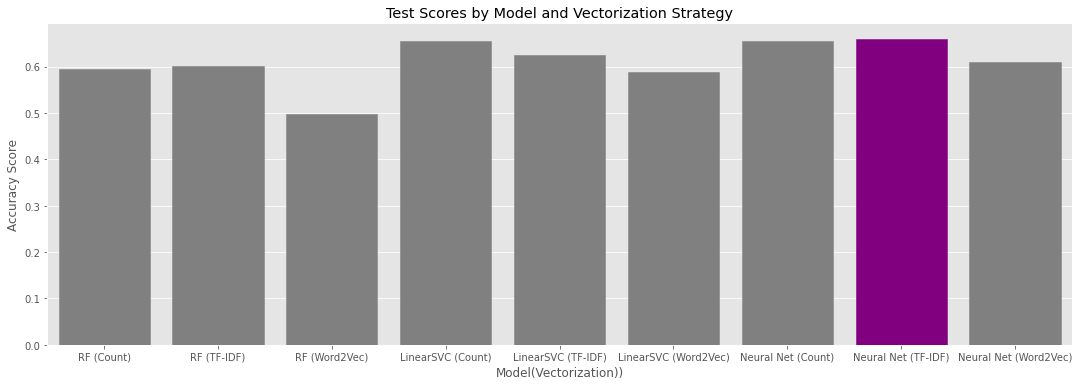

In [128]:
# visualize testing scores
test_labels = pd.Series(['RF (Count)',
                         'RF (TF-IDF)',
                         'RF (Word2Vec)',
                         'LinearSVC (Count)',
                         'LinearSVC (TF-IDF)',
                         'LinearSVC (Word2Vec)',
                         'Neural Net (Count)',
                         'Neural Net (TF-IDF)',
                         'Neural Net (Word2Vec)'])

test_acc = pd.Series(score_list)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=test_labels, y=test_acc, color='grey')
plt.tight_layout()
plt.title('Test Scores by Model and Vectorization Strategy')
plt.xlabel('Model(Vectorization))')
plt.ylabel('Accuracy Score')

# highlight the model/vectorization strategy with highest testing accuracy
max_height = max(score_list)
for bar in ax.patches:
    if bar.get_height() == max_height:
        bar.set_color('purple')
    else:
        bar.set_color('grey')
        
plt.show()

Looking at the comparison of accuracy scores between our different model, it appears using a neural network with TF-IDF vectorized data is producing the best results.  Additionally, when considering training times, LinearSVC on count vectorized data performed the best, with Neural Networks coming second.  Random Forest training times, including grid search seemed to take the longest, especially when including a large number of grid search params. Despite longer training time than LinearSVC, training time is not large enough to offset gains in performance. 

Now run model on full training / test set with this model.  Will include one additional epoch to try and improve testing results, without overfitting too much to training data. 

In [139]:
# build model
best_model = build_ngram_model(input_shape=X_train_tfidf.shape[1:],
                               last_units=last_layer_units,
                               last_activation=last_layer_activation)

# train with 3 epochs
best_model.fit(X_train_tfidf, y_train_encoded, 
                epochs=3,
                batch_size=100,
                validation_split=0.2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_49 (Dropout)         (None, 37886)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 50)                1894350   
_________________________________________________________________
dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 153       
Total params: 1,897,053
Trainable params: 1,897,053
Non-trainable params: 0
___________________________________________

None

Train on 5348 samples, validate on 1337 samples
Epoch 1/3
5348/5348 [==============================] - 7s 1ms/step - loss: 0.9874 - accuracy: 0.5931 - val_loss: 0.8643 - val_accuracy: 0.6028
Epoch 2/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.8295 - accuracy: 0.6060 - val_loss: 0.8087 - val_accuracy: 0.6058
Epoch 3/3
5348/5348 [==============================] - 6s 1ms/step - loss: 0.7446 - accuracy: 0.6440 - val_loss: 0.7756 - val_accuracy: 0.6268


In [140]:
_, best_train_score = best_model.evaluate(X_train_tfidf, y_train_encoded, verbose=0)
_, best_test_score = best_model.evaluate(X_test_tfidf, y_test_encoded, verbose=0)

print(f'Train Accuracy (Neural Network / TF-IDF Vectorized): {best_train_score}')
print(f'Test Accuracy (Neural Network / TF-IDF Vectorized): {best_test_score}')

Train Accuracy (Neural Network / TF-IDF Vectorized): 0.7094988822937012
Test Accuracy (Neural Network / TF-IDF Vectorized): 0.638851523399353


Looking at the final best model selected, the neural network vectorized using TF-IDF data, we see testing scores of 64%, and training scores close to 70%.  The closeness in training and testing scores implies we are no longer overfitting to the training data.  

When considering a balanced dataset with simple model that could achieve ~33% accuracy with three classes to choose from, our model is vastly outperforming that.  Also, when considering our specific case of imbalanced data, we know that the neutral class takes up roughly ~60% of the entire dataset. In that case, a simple model could achieve up to ~60% accuracy score.  Even in this scenario, our best identified model is outperforming this with accuracy scores on testing set close to 64%.  

When considering these results in the real world, our classifier should correctly be able to identify whether a tweet is negative, positive, or neutral about 64% of the time.  These results are somewhat strong, but given the initial class imbalance and lack of negative class entries, we would likely hope to achieve more data in the future to further improve results. 